# **Experiment 2b | EC69210**
**Code Authors:** Irsh Vijay (21EC39055) and Aditya Raj (21EC39001) \

## Mandatory Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import Subset, DataLoader

from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import random
from tqdm import tqdm
import os
from PIL import Image

## Utils

In [ ]:
# Config

class RunConfig:
    def __init__(self, config_path="config.yaml"):
        with open(config_path, "r") as file:
            content = yaml.safe_load(file)
        self.__dict__.update(content)

    def __repr__(self):
        return yaml.dump(self.__dict__)

In [ ]:
# Logging Utils

class MyLogger:
    def __init__(self):
        self.cached_df = None

    def log_metrics(self, dictionary, index_key="epoch"):
        clear_output(wait=True)

        if self.cached_df is not None:
            oncoming = pd.DataFrame.from_records([dictionary])
            if index_key in oncoming.columns:
                oncoming = oncoming.set_index(index_key)
            self.cached_df = pd.concat([self.cached_df, oncoming])
        else:
            self.cached_df = pd.DataFrame.from_records([dictionary])

        if index_key in self.cached_df.columns:
            self.cached_df = self.cached_df.set_index(index_key)
        display(self.cached_df)

    def plot_run(self, keys=None, log=False):
        if keys is None:
            keys = self.cached_df.columns

        for key in keys:
            plt.plot(self.cached_df[key], label=key)

        if log:
            plt.yscale("log")
        plt.legend()
        plt.show()

In [ ]:
def set_global_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

set_global_seed(42)

In [ ]:
def show_image_samples(dataset, idx2class=None):
    sampled = random.sample(range(len(dataset)), 9)
    sampled = [(dataset[i][0], dataset[i][1]) for i in sampled]
    fig, axs = plt.subplots(3, 3)
    plt.suptitle('Sample Images')
    for i, (img, label) in enumerate(sampled):
        ax = axs[i // 3, i % 3]
        ax.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
        if idx2class:
            label = idx2class[label]
        ax.set_title(label)
        ax.axis('off')

In [ ]:
# For Explainability

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device
        self.gradients = None
        self.activations = None

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_layer, target_class=None):
        self.target_layer = target_layer
        self._register_hooks()

        self.model.eval()
        outputs = self.model(input_tensor)

        if target_class is None:
            target_class = outputs.argmax(dim=1).item()

        self.model.zero_grad()
        loss = outputs[:, target_class]
        loss.backward()

        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()
        weights = np.mean(gradients, axis=(2, 3))

        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]

        cam = np.maximum(cam, 0)
        cam = cam - np.min(cam)
        cam = cam / np.max(cam) if np.max(cam) != 0 else cam

        return cam

    def visualize(self, img, target_layer, alpha=0.5, target_class=None):
        img = img.unsqueeze(0)
        img = img.to(self.device)
        cam = self.generate_cam(img, target_layer, target_class)
        img = img.squeeze().cpu().numpy()

        cam = np.interp(cam, (cam.min(), cam.max()), (0, 1))
        cam = np.uint8(cam * 255)

        cmap = plt.get_cmap('magma')
        heatmap = cmap(cam / 255.0)[:, :, :3]

        heatmap = T.ToPILImage()(heatmap)
        heatmap = heatmap.resize((img.shape[1], img.shape[0]))
        heatmap = T.ToTensor()(heatmap).permute(1, 2, 0).numpy()

        superimposed_img = (1 - alpha) * np.stack([img]*3, axis=-1) + alpha * heatmap

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(img, cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Heatmap")
        plt.imshow(heatmap)
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Superimposed")
        plt.imshow(superimposed_img)
        plt.axis("off")

        plt.show()

## Architecture
![image](https://drive.google.com/uc?export=view&id=1h6bDJ-yRs8-gbhfE8TfGgbPXulMpbE1z)

In [ ]:
# Training

class SkipConnectedBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)


class ResNet9(nn.Module):
    def __init__(self, num_classes=10, num_color_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(num_color_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.resblock1 = SkipConnectedBlock(128, 128, 128)
        self.resblock2 = SkipConnectedBlock(128, 256, 256)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(512)

        self.resblock3 = SkipConnectedBlock(512, 512, 512)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.resblock3(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path, weights_only=True))

    def num_parameters(self):
        print(f"Total Params: {sum(p.numel() for p in self.parameters())} | Trainable Params: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def freeze(self, *layers):
        if len(layers) == 0:
            for param in self.parameters():
                param.requires_grad = False
        else:
            for layer in layers:
                for param in self.__getattr__(layer).parameters():
                    param.requires_grad = False

    def unfreeze(self, *layers):
        for layer in layers:
            for param in self.__getattr__(layer).parameters():
                param.requires_grad = True

In [ ]:
try_model = ResNet9(10)

inputs = torch.rand(32, 1, 32, 32)
outputs = try_model(inputs)
outputs.shape # expected (32, 10)

torch.Size([32, 10])

## Training

In [ ]:
def start_run(model, train_loader, val_loader, test_loader, criterion, optimizer, config, target_layer):
    device = torch.device(config.train["device"])
    model = model.to(device)

    num_epochs = config.train["num_epochs"]
    grad_clip = config.train["grad_clip"]
    grad_accumulation_steps = config.train["grad_accum_steps"]
    do_validation = config.train["do_validation"]

    print('Starting Training with the following configuration:')
    print(config)

    if config.logging['print_every'] != 0:
        logger = MyLogger()

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        optimizer.zero_grad()
        for step, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch: {epoch+1}/{num_epochs}", leave=False), 1):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss / grad_accumulation_steps

            loss.backward()

            if (step + 1) % grad_accumulation_steps == 0:
                if grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        logdict = {"epoch": epoch+1, "train_loss": epoch_loss, "train_accuracy": train_accuracy}

        if do_validation:
            model.eval()
            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
            logdict["val_loss"] = val_loss
            logdict["val_accuracy"] = val_accuracy

        if (epoch+1) % config.logging['print_every'] == 0:
            logger.log_metrics(logdict)
            gc = GradCAM(model)

            random_batch_idx = random.randint(0, len(val_loader) - 1)
            for idx, (images, labels) in enumerate(val_loader):
                if idx == random_batch_idx:
                    random_img_idx = random.randint(0, len(images) - 1)
                    if target_layer is not None:
                      gc.visualize(images[random_img_idx], target_layer, alpha=0.5, target_class=labels[random_img_idx].item())
                    break

    if config.logging["save_model"]:
        model_save_path = config.logging["model_save_path"]
        model.save(model_save_path)
        print(f"Model saved to {model_save_path}")

    print(f"Test Accuracy: {evaluate_model(model, test_loader, criterion, device)[1]:.2%}")

    return model, logger

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    model = model.to(device)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    loss = running_loss / len(dataloader)
    accuracy = correct / total
    return loss, accuracy

## MNIST

Transforms:
- Resize to (36, 36)
- RandomCrop
- Grayscale
- RandomInvert (so model learns boundaries rather than empty space)

In [ ]:
transforms = T.Compose([
    T.Resize((36, 36)),
    T.RandomCrop((32, 32)),
    T.ToTensor(),
    T.Grayscale(num_output_channels=1),
    T.RandomInvert()
])

In [ ]:
train_n_val_dataset = torchvision.datasets.MNIST(root='./data/train', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST(root='./data/test', train=False, download=True, transform=transforms)

train_dataset = Subset(train_n_val_dataset, range(50000))
val_dataset = Subset(train_n_val_dataset, range(50000, len(train_n_val_dataset)))

del train_n_val_dataset

print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")

Train size: 50000 | Val size: 10000 | Test size: 10000


Labels:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


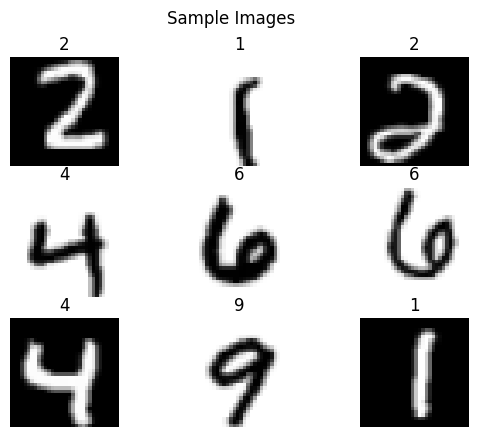

In [ ]:
show_image_samples(test_dataset)
print("Labels: ", set(test_dataset.targets.tolist()))

In [ ]:
config = f"""
train:
  batch_size: 256
  num_epochs: 5
  learning_rate: 0.001
  optimizer: "adam"
  device: "{("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))}"
  grad_clip: 0
  grad_accum_steps: 1
  do_validation: true

model:
  num_classes: 10  # 10 classes for MNIST

logging:
  print_every: 1
  save_model: true
  model_save_path: "./trained/mnist.pth"
"""

os.makedirs('configs/', exist_ok=True)
os.makedirs('trained/', exist_ok=True)

with open('configs/mnist_config.yaml', 'w') as f:
  f.write(config)

In [ ]:
config = RunConfig('configs/mnist_config.yaml')
model = ResNet9(num_classes=config.model['num_classes'])

_ = model.num_parameters()

Total Params: 7195594 | Trainable Params: 7195594


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config.train['batch_size'], shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=config.train['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.train['batch_size'], shuffle=False)

,train_loss,train_accuracy,val_loss,val_accuracy
epoch,,,,
1,0.395450,0.88890,0.179234,0.9424
2,0.060205,0.98238,0.065676,0.9799
3,0.042013,0.98772,0.066741,0.9787
4,0.036423,0.98846,0.056441,0.9831
5,0.030900,0.98998,0.068186,0.9765


/Users/irsh/Documents/workdir/ec69210/exp2/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


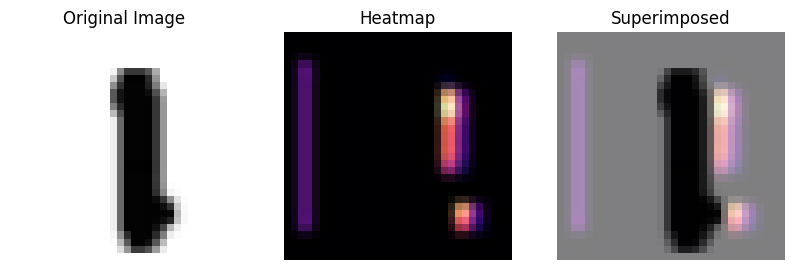

Model saved to ./trained/mnist.pth


Test Accuracy: 97.63%


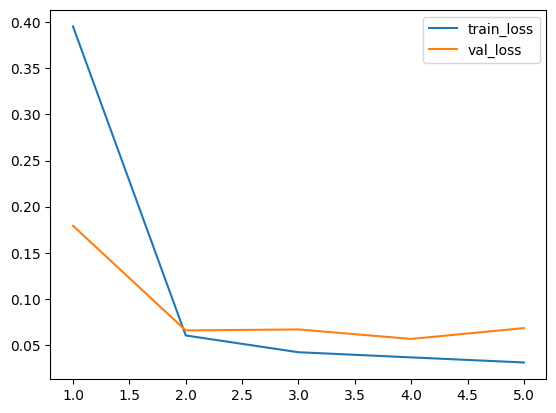

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.train["learning_rate"])

target_layer = 'resblock1.conv1'

trained_model, logger = start_run(model, train_loader, val_loader, test_loader, criterion, optimizer, config, target_layer)
logger.plot_run(keys=['train_loss', 'val_loss'])

## TeluguMNIST

In [ ]:
%%capture
!unzip dataset.zip

In [ ]:
class TeluguDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, num_augmentations=1):
        self.root = root
        self.transform = transform
        self.classes = os.listdir(root)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        self.targets = []
        self.num_augmentations = num_augmentations

        for cls in self.classes:
            cls_dir = os.path.join(root, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                self.samples.append((self._read_image(img_path), self.class_to_idx[cls]))
                self.targets.append(cls)

    def _read_image(self, img_path):
        img = Image.open(img_path)
        return img

    def __len__(self):
        return len(self.samples)*self.num_augmentations

    def __getitem__(self, idx):
        img, idx = self.samples[idx//self.num_augmentations]
        if hasattr(self, "transform"):
            img = self.transform(img)

        return img, idx

train_n_val_dataset = TeluguDataset(root='./dataset/train', transform=transforms, num_augmentations=3)
test_dataset = TeluguDataset(root='./dataset/test', transform=transforms)

train_dataset = Subset(train_n_val_dataset, range(len(train_n_val_dataset)-len(test_dataset)))
val_dataset = Subset(train_n_val_dataset, range(len(train_n_val_dataset)-len(test_dataset), len(train_n_val_dataset)))

del train_n_val_dataset

print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")

Train size: 3160 | Val size: 290 | Test size: 290


In [ ]:
class2idx = test_dataset.class_to_idx
idx2class = {v: k for k, v in class2idx.items()}

Labels:  [3, 5, 7, 0, 2, 1, 9, 4, 8, 6]


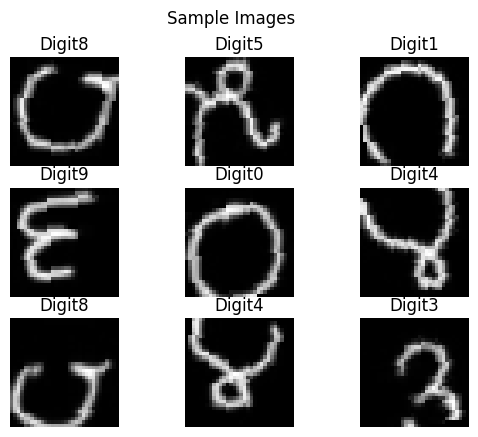

In [ ]:
show_image_samples(test_dataset, idx2class)
print("Labels: ", [class2idx[char] for char in set(test_dataset.targets)])

In [ ]:
config = f"""
train:
  batch_size: 128
  num_epochs: 5
  learning_rate: 0.001
  optimizer: "adam"
  device: "{("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))}"
  grad_clip: 0
  grad_accum_steps: 1
  do_validation: true

model:
  num_classes: 10  # 10 classes for MNIST

logging:
  print_every: 1
  save_model: true
  model_save_path: "./trained/telugu.pth"
"""

os.makedirs('configs/', exist_ok=True)
os.makedirs('trained/', exist_ok=True)

with open('configs/telugu_config.yaml', 'w') as f:
  f.write(config)

In [ ]:
config = RunConfig('configs/telugu_config.yaml')
model = ResNet9(num_classes=config.model['num_classes'])

_ = model.num_parameters()

Total Params: 7195594 | Trainable Params: 7195594


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config.train['batch_size'], shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=config.train['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.train['batch_size'], shuffle=False)

,train_loss,train_accuracy,val_loss,val_accuracy
epoch,,,,
1,0.520744,0.860759,2.237585,0.451724
2,0.044531,0.990823,0.050710,0.996552
3,0.017191,0.997468,0.036661,0.989655
4,0.010721,0.998101,0.052714,0.986207
5,0.006452,0.999051,0.017881,0.989655


Model saved to ./trained/telugu.pth


Test Accuracy: 99.66%


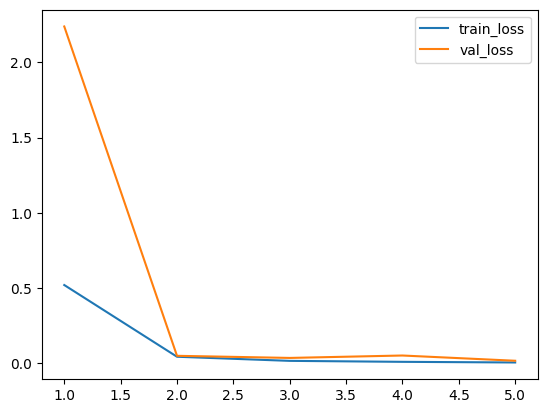

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.train["learning_rate"])

trained_model, logger = start_run(model, train_loader, val_loader, test_loader, criterion, optimizer, config, target_layer)
logger.plot_run(keys=['train_loss', 'val_loss'])

## Finetuning

In [ ]:
model = ResNet9(10)
model.load('trained/mnist.pth')

model.freeze()
model.unfreeze('fc')

_ = model.num_parameters()

Total Params: 7195594 | Trainable Params: 5130


In [ ]:
config = f"""
train:
  batch_size: 128
  num_epochs: 20
  learning_rate: 0.001
  optimizer: "adam"
  device: "{("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))}"
  grad_clip: 0
  grad_accum_steps: 1
  do_validation: true

model:
  num_classes: 10  # 10 classes for MNIST

logging:
  print_every: 1
  save_model: true
  model_save_path: "./trained/finetuned.pth"
"""

os.makedirs('configs/', exist_ok=True)
os.makedirs('trained/', exist_ok=True)

with open('configs/finetuning_config.yaml', 'w') as f:
  f.write(config)

config = RunConfig('configs/finetuning_config.yaml')

,train_loss,train_accuracy,val_loss,val_accuracy
epoch,,,,
1,2.257599,0.146519,3.458873,0.100000
2,2.056324,0.212342,3.111265,0.100000
3,1.981453,0.283228,2.374217,0.237931
4,1.900365,0.324051,2.447764,0.396552
5,1.848633,0.361392,2.436183,0.351724
6,1.802392,0.393987,2.382315,0.400000
7,1.754372,0.428797,2.313620,0.372414
8,1.722386,0.432278,2.169305,0.424138
9,1.695656,0.477215,2.143418,0.465517


Model saved to ./trained/finetuned.pth


Test Accuracy: 52.76%


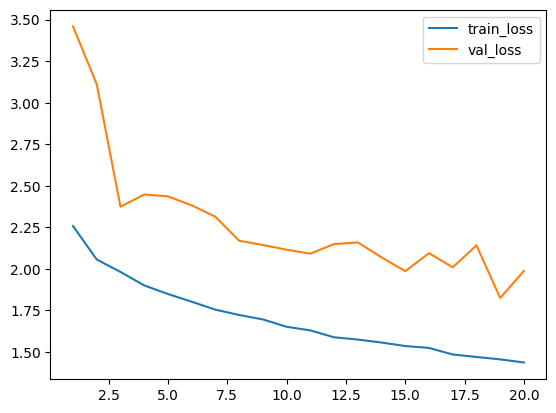

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.train["learning_rate"])

target_layer = None

trained_model, logger = start_run(model, train_loader, val_loader, test_loader, criterion, optimizer, config, target_layer)
logger.plot_run(keys=['train_loss', 'val_loss'])

## Hindi Dataset Preparation

In [ ]:
!gdown 1wEeKeFsH8YKRANENVg98kMX_yIf1CnU7

Downloading...
From: https://drive.google.com/uc?id=1wEeKeFsH8YKRANENVg98kMX_yIf1CnU7
To: /Users/irsh/Documents/workdir/ec69210/exp2/hindi_char_grid.jpg
100%|████████████████████████████████████████| 245k/245k [00:00<00:00, 1.16MB/s]


In [ ]:
img = np.array(Image.open('hindi_char_grid.jpg').convert('L').resize((810, 540)))
height, width = img.shape

n_rows = 18
n_cols = 27

imgs = [[] for i in range(0, height, height//n_rows)]

for idx, i in enumerate(range(0, height, height//n_rows)):
    for j in range(0, width, width//n_cols):
        imgs[idx].append(img[i: i+height//n_rows, j: j+width//n_cols])

In [ ]:
idx_mapping = [0, 0, 1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9]

save_path = 'hindi_ds/'

os.makedirs(save_path, exist_ok=True)
for idx in idx_mapping:
    os.makedirs(save_path+"train/"+str(idx), exist_ok=True)
    os.makedirs(save_path+"test/"+str(idx), exist_ok=True)

for i in range(len(imgs)):
    for j in range(len(imgs[0])):
        if j < len(imgs[0]) * 0.85:
          Image.fromarray(imgs[i][j]).save(save_path+f"train/{idx_mapping[i]}/image_{j}.jpg")
        else:
          Image.fromarray(imgs[i][j]).save(save_path+f"test/{idx_mapping[i]}/image_{j}.jpg")

In [ ]:
train_n_val_dataset = TeluguDataset(root='./hindi_ds/train', transform=transforms, num_augmentations=5)
test_dataset = TeluguDataset(root='./hindi_ds/test', transform=transforms)

train_dataset = Subset(train_n_val_dataset, range(len(train_n_val_dataset)-len(test_dataset)))
val_dataset = Subset(train_n_val_dataset, range(len(train_n_val_dataset)-len(test_dataset), len(train_n_val_dataset)))

del train_n_val_dataset

print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")

Train size: 1070 | Val size: 80 | Test size: 80


In [ ]:
class2idx = test_dataset.class_to_idx
idx2class = {v: k for k, v in class2idx.items()}

Labels:  [2, 7, 0, 4, 3, 5, 1, 8, 9, 6]


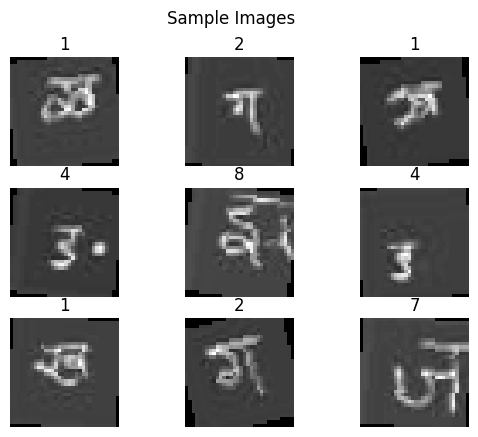

In [ ]:
show_image_samples(test_dataset, idx2class)
print("Labels: ", [class2idx[char] for char in set(test_dataset.targets)])

In [ ]:
config = f"""
train:
  batch_size: 128
  num_epochs: 20
  learning_rate: 0.0001
  optimizer: "adam"
  device: "{("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))}"
  grad_clip: 0
  grad_accum_steps: 1
  do_validation: true

model:
  num_classes: 10  # 10 classes for MNIST

logging:
  print_every: 1
  save_model: true
  model_save_path: "./trained/hindi.pth"
"""

os.makedirs('configs/', exist_ok=True)
os.makedirs('trained/', exist_ok=True)

with open('configs/hindi_config.yaml', 'w') as f:
  f.write(config)

In [ ]:
config = RunConfig('configs/hindi_config.yaml')
model = ResNet9(num_classes=config.model['num_classes'])

_ = model.num_parameters()

Total Params: 7195594 | Trainable Params: 7195594


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=config.train['batch_size'], shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=config.train['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.train['batch_size'], shuffle=False)

,train_loss,train_accuracy,val_loss,val_accuracy
epoch,,,,
1,1.891597,0.374766,2.476849,0.1000
2,1.166339,0.700000,3.431585,0.1000
3,0.757796,0.814019,4.135134,0.1000
4,0.478827,0.893458,3.189207,0.1750
5,0.287203,0.957009,2.276021,0.2250
6,0.209403,0.969159,0.748263,0.7875
7,0.152927,0.981308,0.544382,0.8000
8,0.118201,0.988785,0.877586,0.7500
9,0.100188,0.988785,0.401680,0.8750


/Users/irsh/Documents/workdir/ec69210/exp2/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


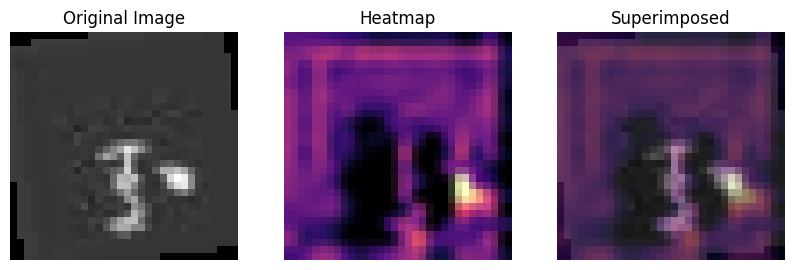

Model saved to ./trained/hindi.pth


Test Accuracy: 92.50%


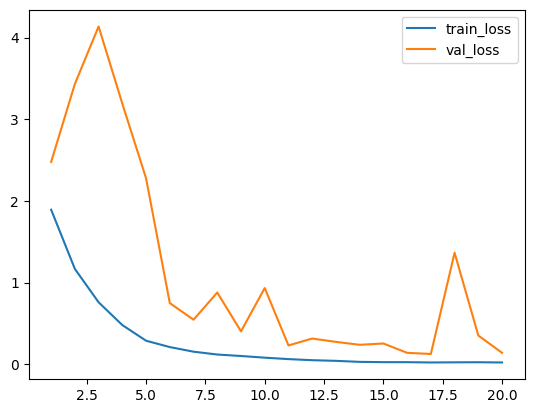

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.train["learning_rate"])

target_layer = 'resblock1.conv2'

trained_model, logger = start_run(model, train_loader, val_loader, test_loader, criterion, optimizer, config, target_layer)
logger.plot_run(keys=['train_loss', 'val_loss'])